import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from pathlib import Path
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import altair as alt
from sklearn.ensemble import GradientBoostingRegressor
from pyspark import SparkContext
from sklearn.preprocessing import OneHotEncoder
# ^^^ pyforest auto-imports - don't write above this line
# Imports

## Libraries

In [145]:
import geopandas
import unidecode
import warnings
warnings.filterwarnings('ignore')

## Data

In [51]:
pct_df = pd.read_csv("./my_saved_data/final_nyc_chi_dal_sf_df.csv", index_col=0)
pct_df.columns = ['Region', "NYC", "Chi", "Dal", "SF"]

<IPython.core.display.Javascript object>

In [52]:
pct_df.head(2)

,Region,NYC,Chi,Dal,SF
0,Aguascalientes,0.01,0.0,0.00,0.00
1,Baja California,0.07,0.0,0.02,0.04


In [53]:
with open("./my_saved_data/restaurant_counts.pickle", "rb+") as f:
    rest_counts = pickle.load(f)

<IPython.core.display.Javascript object>

In [54]:
rest_counts

{'NYC': 20, 'Chi': 5, 'Dal': 27, 'SF': 14}

In [55]:
all_df = pd.read_csv("./my_saved_data/Final_restaurant_list.csv", index_col=0)

<IPython.core.display.Javascript object>

In [56]:
all_df.head(2)

,City,Match,Region
chilango,Chicago,chilango,Ciudad de Mexico
los alamos,Chicago,alamos,Tabasco


In [186]:
all_rest_df = pd.read_csv("./my_saved_data/all_restaurants_df.csv", index_col=0)

<IPython.core.display.Javascript object>

In [188]:
all_rest_df.head(2)

,Count_of_restaurants,Percent_of_all_restaurants
Puebla,33,0.12
Yucatan,22,0.08


# EDA

## What are the biggest regions for each city?

In [57]:
pct_df.sort_values(by=['NYC'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF
20,Puebla,0.37,0.0,0.01,0.00
29,Yucatan,0.13,0.0,0.04,0.11
5,Chihuahua,0.07,0.0,0.01,0.07
1,Baja California,0.07,0.0,0.02,0.04
19,Oaxaca,0.05,0.0,0.01,0.02


In [58]:
# chicago only has 5 regions represented (there were only 6 restaurant matches)
pct_df.sort_values(by=['Chi'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF
12,Jalisco,0.02,0.29,0.04,0.02
15,Michoacan de Ocampo,0.00,0.14,0.21,0.00
6,Ciudad de Mexico,0.00,0.14,0.01,0.00
25,Tabasco,0.01,0.14,0.04,0.04
10,Guerrero,0.02,0.14,0.07,0.04


In [59]:
pct_df.sort_values(by=['Dal'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF
15,Michoacan de Ocampo,0.00,0.14,0.21,0.00
3,Campeche,0.00,0.00,0.10,0.04
28,Veracruz,0.03,0.00,0.09,0.04
10,Guerrero,0.02,0.14,0.07,0.04
11,Hidalgo,0.02,0.00,0.06,0.00


In [60]:
pct_df.sort_values(by=['SF'], ascending=False)[0:5]

,Region,NYC,Chi,Dal,SF
9,Guanajuato,0.00,0.0,0.01,0.40
29,Yucatan,0.13,0.0,0.04,0.11
5,Chihuahua,0.07,0.0,0.01,0.07
13,Mexico,0.01,0.0,0.05,0.07
3,Campeche,0.00,0.0,0.10,0.04


## How much overlap is there in the major regions for each group?

In [61]:
nyc_top5 = list(pct_df.sort_values(by=['NYC'], ascending=False)[0:5]['Region'])

In [62]:
chi_top5 = list(pct_df.sort_values(by=['Chi'], ascending=False)[0:5]['Region'])

In [63]:
dal_top5 = list(pct_df.sort_values(by=['Dal'], ascending=False)[0:5]['Region'])

In [64]:
sf_top5 =list(pct_df.sort_values(by=['SF'], ascending=False)[0:5]['Region'])

In [65]:
print(nyc_top5)
print(chi_top5)
print(dal_top5)
print(sf_top5)

['Puebla', 'Yucatan', 'Chihuahua', 'Baja California', 'Oaxaca']
['Jalisco', 'Michoacan de Ocampo', 'Ciudad de Mexico', 'Tabasco', 'Guerrero']
['Michoacan de Ocampo', 'Campeche', 'Veracruz', 'Guerrero', 'Hidalgo']
['Guanajuato', 'Yucatan', 'Chihuahua', 'Mexico', 'Campeche']


In [66]:
top5_region_dict = {y:0 for x in [nyc_top5, chi_top5, dal_top5, sf_top5] for y in x}

In [67]:
for sublist in [nyc_top5, chi_top5, dal_top5, sf_top5]:
    for region in sublist:
        for key, value in top5_region_dict.items():
            if region == key:
                top5_region_dict[key] += 1

In [68]:
# only showing the most common regions
top5_more_than_2_list = []
for key, value in top5_region_dict.items():
    if value >= 2:
        top5_more_than_2_list.append(key)

In [69]:
top5_more_than_2_list

['Yucatan', 'Chihuahua', 'Michoacan de Ocampo', 'Guerrero', 'Campeche']

### Top 2 countries

In [70]:
nyc_top2 = list(pct_df.sort_values(by=['NYC'], ascending=False)[0:2]['Region'])

In [71]:
chi_top2 = list(pct_df.sort_values(by=['Chi'], ascending=False)[0:2]['Region'])

In [72]:
dal_top2 = list(pct_df.sort_values(by=['Dal'], ascending=False)[0:2]['Region'])

In [73]:
sf_top2 =list(pct_df.sort_values(by=['SF'], ascending=False)[0:2]['Region'])

In [74]:
print(nyc_top2)
print(chi_top2)
print(dal_top2)
print(sf_top2)

['Puebla', 'Yucatan']
['Jalisco', 'Michoacan de Ocampo']
['Michoacan de Ocampo', 'Campeche']
['Guanajuato', 'Yucatan']


In [75]:
region_in_top2 = []
for lst in [nyc_top2, chi_top2, dal_top2, sf_top2]:
    for item in lst:
        if item not in region_in_top2:
            region_in_top2.append(item)

In [76]:
region_in_top2

['Puebla',
 'Yucatan',
 'Jalisco',
 'Michoacan de Ocampo',
 'Campeche',
 'Guanajuato']

In [181]:
top2_df = pct_df[pct_df['Region'].isin(region_in_top2)].reset_index(drop=True)
top2_df

,Region,NYC,Chi,Dal,SF
0,Campeche,0.00,0.00,0.10,0.04
1,Guanajuato,0.00,0.00,0.01,0.40
2,Jalisco,0.02,0.29,0.04,0.02
3,Puebla,0.37,0.00,0.01,0.00
4,Yucatan,0.13,0.00,0.04,0.11


# Displaying Data

## Geodataframe

In [135]:
# shapefile issue fixed here: https://github.com/Toblerity/Fiona/issues/548 
# and https://stackoverflow.com/questions/61436956/set-shape-restore-shx-config-option-to-yes-to-restore-or-create-it
mex_gdf = geopandas.read_file("./data/MEX_adm1.shp")

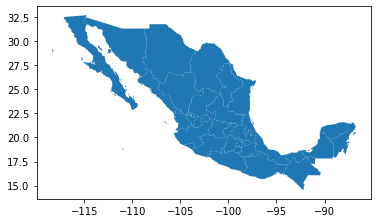

In [136]:
mex_gdf.plot()

### Removing Unnecessary columns

In [138]:
mex_gdf.drop(columns = ['ID_0', 'ID_1', 'ISO', 'NAME_0', 'HASC_1', 'CC_1', 'VALIDFR_1', 'VALIDTO_1', 'REMARKS_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1'], inplace=True)

In [139]:
regions = [unidecode.unidecode(x) for x in mex_gdf['NAME_1']]
mex_gdf['Region'] = regions

### Adding pct_df data

In [141]:
# which regions are missing in pct_df 
pct_df_names = list(pct_df['Region'])

In [142]:
len(pct_df_names)

29

In [143]:
# truly missing regions are: queretaro, coahuila, quintana roo
for x in regions:
    if x not in pct_df_names:
        print(x)

Coahuila
Distrito Federal
Michoacan
Queretaro
Quintana Roo


#### Renaming 2 regions in pct_df

In [146]:
pct_df['Region'][6] = 'Distrito Federal'
pct_df['Region'][15] = 'Michoacan'

#### Joining the two 

In [147]:
mex_gdf2 = mex_gdf.merge(pct_df, left_on = 'Region', right_on = 'Region', how='outer')

In [148]:
mex_gdf2.fillna(value = 0, inplace=True)

In [149]:
mex_gdf2.head(2)

,NAME_1,Shape_Leng,Shape_Area,geometry,Region,NYC,Chi,Dal,SF
0,Aguascalientes,2.805224,0.455085,"POLYGON ((-102.12611 21.73960, -102.13392 21.7...",Aguascalientes,0.01,0.0,0.00,0.00
1,Baja California,30.144683,6.935158,"MULTIPOLYGON (((-114.75681 18.37097, -114.7568...",Baja California,0.07,0.0,0.02,0.04


## Choropleth maps
consistent scale: https://github.com/geopandas/geopandas/issues/1019

### Consistent scale

In [150]:
bin_range_times10 = list(range(0, 5))
bin_range = np.array(bin_range_times10) / 10

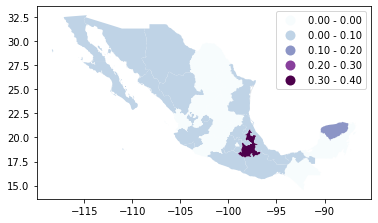

In [151]:
# NYC 
mex_gdf2.plot(column='NYC', legend=True, cmap='BuPu', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

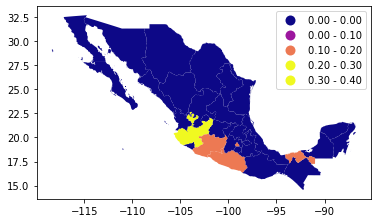

In [152]:
# chicago
mex_gdf2.plot(column='Chi', legend=True, cmap = 'plasma',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

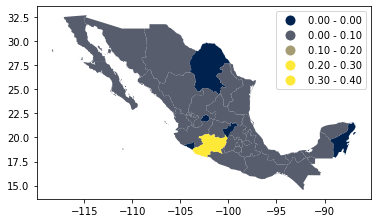

In [153]:
# dal
mex_gdf2.plot(column='Dal', legend=True, cmap = 'cividis',
              scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

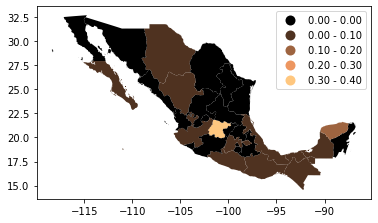

In [154]:
# sf
mex_gdf2.plot(column='SF', legend=True, cmap = 'copper',scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))

### Plotting all cities together
multiple axes: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html

<IPython.core.display.Javascript object>

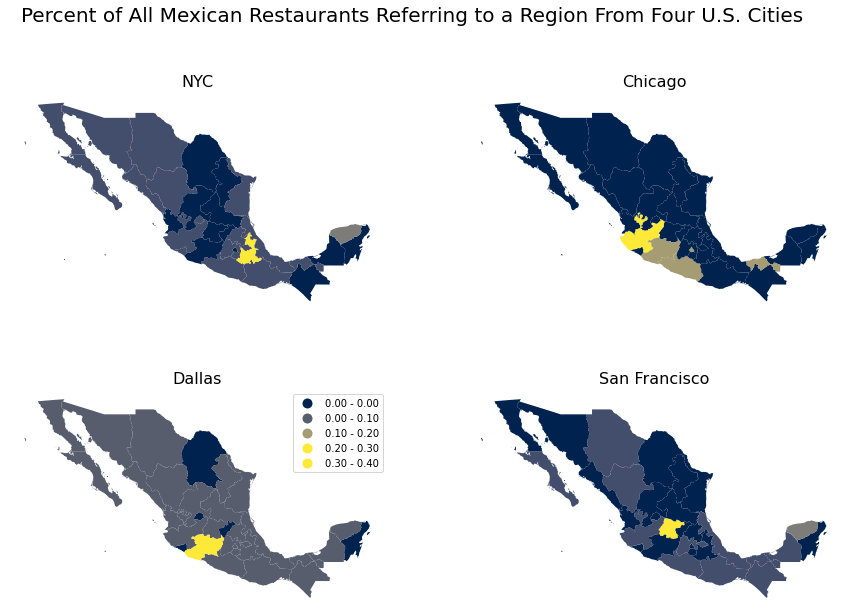

In [155]:
fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
mex_gdf2.plot(
    column='NYC', ax=ax1, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax1.set_title('NYC', fontsize=16)
mex_gdf2.plot(
    column='Chi', ax=ax2, cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax2.set_title('Chicago', fontsize=16)
mex_gdf2.plot(
    column='Dal', ax=ax3,  cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range), legend=True)
ax3.set_title('Dallas', fontsize=16)
mex_gdf2.plot(
    column='SF', ax=ax4,cmap = 'cividis', scheme='User_Defined',
              classification_kwds=dict(bins=bin_range))
ax4.set_title('San Francisco', fontsize=16)
for ax in (ax1,ax2,ax3,ax4,):
    ax.axis('off')
# plt.savefig("./my_saved_data/Map_of_regions_from_all_cities.png", pad_inches='tight', orientation='landscape')

## Percent of Restaurants that Have a Region Associated With Them

In [156]:
#NYC had 849 unique mexican restaurants, 20 matched
print(f"The percent of restaurants that had a name attached to a region was {round(86/849, 2) * 100}%")

The percent of restaurants that had a name attached to a region was 10.0%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

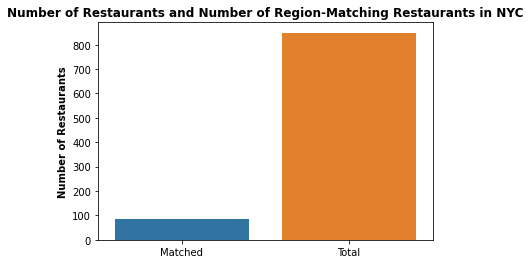

In [183]:
ax = sns.barplot(x=['Matched', 'Total'], y=[86, 849])
ax.set_title('Number of Restaurants and Number of Region-Matching Restaurants in NYC', fontsize='large', fontweight='bold')
ax.set_ylabel("Number of Restaurants", fontweight='bold')
plt.show()
# plt.savefig("./my_saved_data/Matched_restaurants_vs_total.png", pad_inches='tight')

## Most Diverse Mexican Population

In [158]:
all_df.City.unique()

array(['Chicago', 'Dallas', 'SF', 'NYC'], dtype=object)

In [159]:
all_df.head(2)

,City,Match,Region
chilango,Chicago,chilango,Ciudad de Mexico
los alamos,Chicago,alamos,Tabasco


In [161]:
nunique_regions = all_df.groupby(['City']).Region.nunique()
list(nunique_regions)

[5, 28, 21, 14]

In [162]:
nunique_restaurants = all_df.groupby(['City']).Region.count()
list(nunique_restaurants)

[6, 140, 86, 45]

In [163]:
nunique_regions.keys()

Index(['Chicago', 'Dallas', 'NYC', 'SF'], dtype='object', name='City')

In [164]:
pct_unique = np.array(list(nunique_regions)) / np.array(list(nunique_restaurants))
pct_unique

array([0.83333333, 0.2       , 0.24418605, 0.31111111])

In [165]:
pct_unique_dict = dict(zip(nunique_regions.keys(), pct_unique))
pct_unique_dict

{'Chicago': 0.8333333333333334,
 'Dallas': 0.2,
 'NYC': 0.2441860465116279,
 'SF': 0.3111111111111111}

### Saving Diversity of Restaurants Dict

In [166]:
# with open ('./my_saved_data/restaurant_region_diversity.pickle', 'wb+') as f:
#     pickle.dump(pct_unique_dict, f)

## Count of matching Restaurants Across Cities

In [167]:
cities = list(nunique_regions.keys())

In [168]:
num_of_restaurants = list(nunique_restaurants)
num_of_restaurants

[6, 140, 86, 45]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

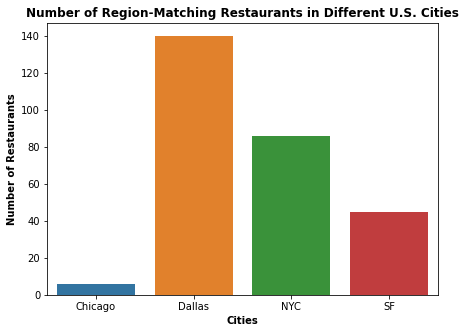

In [179]:
fig= plt.subplots(figsize=(7, 5))
ax = sns.barplot(x = cities, y = num_of_restaurants)
ax.set_title('Number of Region-Matching Restaurants in Different U.S. Cities', fontsize='large',
             fontweight='bold')
ax.set_ylabel("Number of Restaurants", fontweight='bold')
ax.set_xlabel("Cities", fontweight='bold')
# plt.savefig("./my_saved_data/number_of_restaurants_for_each_city.png", pad_inches='tight')

# Considering All Data Together

In [257]:
all_rest_df.sort_values(by = ['Percent_of_all_restaurants'], ascending=False).head(10)

,Region,Count_of_restaurants,Percent_of_all_restaurants
0,Puebla,33,0.12
22,Michoacan de Ocampo,31,0.11
1,Yucatan,22,0.08
26,Guanajuato,20,0.07
6,Veracruz,17,0.06
25,Campeche,16,0.06
10,Guerrero,15,0.05
8,Hidalgo,10,0.04
11,Jalisco,11,0.04
12,Mexico,11,0.04


In [194]:
for x in all_rest_df.index:
    if x not in list(mex_gdf.Region):
        print(x)

Ciudad de Mexico
Michoacan de Ocampo


In [204]:
mex_gdf['Region'][8] = 'Ciudad de Mexico'
mex_gdf['Region'][15] = "Michoacan de Ocampo"

In [208]:
all_rest_df.reset_index(inplace=True)

In [211]:
all_rest_df.columns = ['Region', "Count_of_restaurants", "Percent_of_all_restaurants"]

In [212]:
mex_gdf3 = mex_gdf.merge(all_rest_df, left_on = 'Region', right_on = 'Region', how='outer')

In [217]:
mex_gdf3.fillna(value = 0, inplace=True)

## Plotting

In [231]:
bin_range_times13 = list(range(0, 13, 2))
bin_range13 = np.array(bin_range_times13) / 100

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

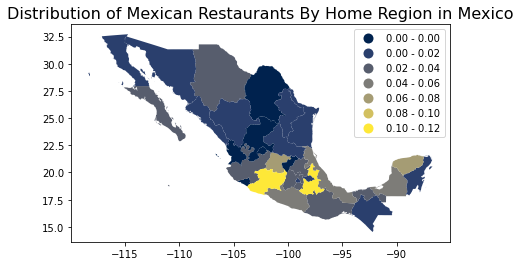

In [256]:
fig, ax = plt.subplots(1, figsize=(8,4))
# fig.title('Percent of All Mexican Restaurants Referring to a Region From Four U.S. Cities', fontsize=20)
mex_gdf3.plot(column='Percent_of_all_restaurants', cmap = 'cividis', legend=True, 
              scheme='User_Defined', ax=ax,
              classification_kwds=dict(bins=bin_range13))
ax.set_title("Distribution of Mexican Restaurants By Home Region in Mexico",fontsize=16)
# plt.savefig("./my_saved_data/Map_of_all_restaurants_and_their_regions.png", pad_inches='tight', orientation='landscape')

# Conclusions

All 4 cities have [Mexican immigrant populations larger than 250k](https://247wallst.com/economy/2017/01/27/us-cities-with-the-most-mexican-immigrants/). Despite this surface similarity, it turns out that they don't all come from similar regions in Mexico. No region was in the top 5 most popular region for more than 2 of these cities. This suggests that immigration from Mexico was not dominated by one region but came from all regions of Mexico (except 3: Quintana Roo, Queretaro, Coahuila). Similarly, we see that there are no single region that makes up the majority of any US city's Mexican population: in all cases, no region accounted for more than 40% of the restaurants with regions associated with their names. This did have some variation, however: in San Francisco Guanajuato accounts for 40% of the restaurants while in Dallas the most dominant group accounts for 21% of the population.

Some shortcomings of this project are the quality of this data: both for the demonym dictionary and the inspection data. The demonym dictionary had many entries, but there were some clear errors, e.g.: the restaurant 'jalisco' in Dallas was originally associated with "Ciudad de Mexico" instead of the region Jalisco (this was corrected). Additionally, it is not clear if **all** restaurants in each city are included in this data, or only restaurants that failed the inspection. In a similar vein, some cities had data that had too low of a quality to be useful (LA). Another problem with this project is deciding when a "match" is legitimate. For example, "Pueblito" ("little town") appeared often and is a town in Queretáro, but do these restaurants refer to this specific town? This was decided on an ad hoc basis and was founded solely on my (non-native) discretion. Lastly, the obvious issue of immediate representation being a marker of the true number of people from a certain region is certainly flawed. Just because there are say, a lot of Italian restaurants in a certain area, does not necessarily mean that there are many (recent) italian immigrants to that area. The popularity of food from certain regions may skew the data. It is my hope, that all regions being represented equally among recent immigrants means that this method is representative of the true Mexican populations of these cities. 

As an interesting side note, it appears that chain migration happens at an extremely micro level. "Tulcingo" appears 5 times in the NYC data despite the fact that the town that it refers to in Mexico, Tulcingo del Valle, has only around [9,000 people living in it](https://es.wikipedia.org/wiki/Municipio_de_Tulcingo)! Perhaps this can be a case where more people from that town currently live in NYC than in the town itself! 